In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [112]:
deliv_times = pd.read_csv('historical_data.csv')
deliv_times.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_dashers,total_busy_dashers,total_outstanding_orders,estimated_order_place_duration,estimated_store_to_consumer_driving_duration
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,1845,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0,446,861.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,5477,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0,446,690.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,5477,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0,446,690.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,5477,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0,446,289.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,5477,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0,446,650.0


In [113]:
deliv_times.created_at = pd.to_datetime(deliv_times.created_at)
deliv_times.actual_delivery_time = pd.to_datetime(deliv_times.actual_delivery_time)
deliv_times['total_duration'] = deliv_times.actual_delivery_time - deliv_times.created_at
deliv_times['total_duration'] = pd.to_timedelta(deliv_times.total_duration).dt.total_seconds()
deliv_times['busy_dashers_ratio'] = deliv_times.total_busy_dashers / (deliv_times.total_onshift_dashers)

In [114]:
unique_ids = deliv_times.store_id.unique()
most_common_cuisines = {id:deliv_times[id == deliv_times.store_id].store_primary_category.mode() for id in unique_ids}

In [115]:
def fill(id):
    try:
        return most_common_cuisines[id].values[0]
    except:
        return np.nan
    
deliv_times['nan-free_store_category'] = deliv_times.store_id.apply(fill)


In [116]:
mkt_ids = pd.get_dummies(deliv_times['market_id'],dtype= float)
mkt_ids= mkt_ids.add_prefix('market_id_')
orderprotocols = pd.get_dummies(deliv_times['order_protocol'],dtype = float)
orderprotocols = orderprotocols.add_prefix('protocol_')
cuisines = pd.get_dummies(deliv_times['nan-free_store_category'],dtype = float)
cuisines = cuisines.add_prefix('category_')

In [117]:
deliv_times = pd.concat([deliv_times,mkt_ids,orderprotocols,cuisines],axis=1)
deliv_times.replace([-np.inf,np.inf],np.nan,inplace=True)
deliv_times.dropna(inplace=True)

In [118]:
deliv_times.drop(columns=['market_id','store_id','created_at','actual_delivery_time','order_protocol','store_primary_category','nan-free_store_category'],inplace=True)

In [119]:
dropindex1 = deliv_times.query('total_onshift_dashers<0').index
dropindex2 = deliv_times.query('total_busy_dashers<0').index
dropindex = dropindex1.union(dropindex2)


In [120]:
deliv_times.drop(index=dropindex,columns=['total_onshift_dashers','total_busy_dashers'],inplace=True)


In [126]:
corrmatrix = deliv_times.corr()
mask = np.triu(np.ones_like(corrmatrix,dtype=bool))

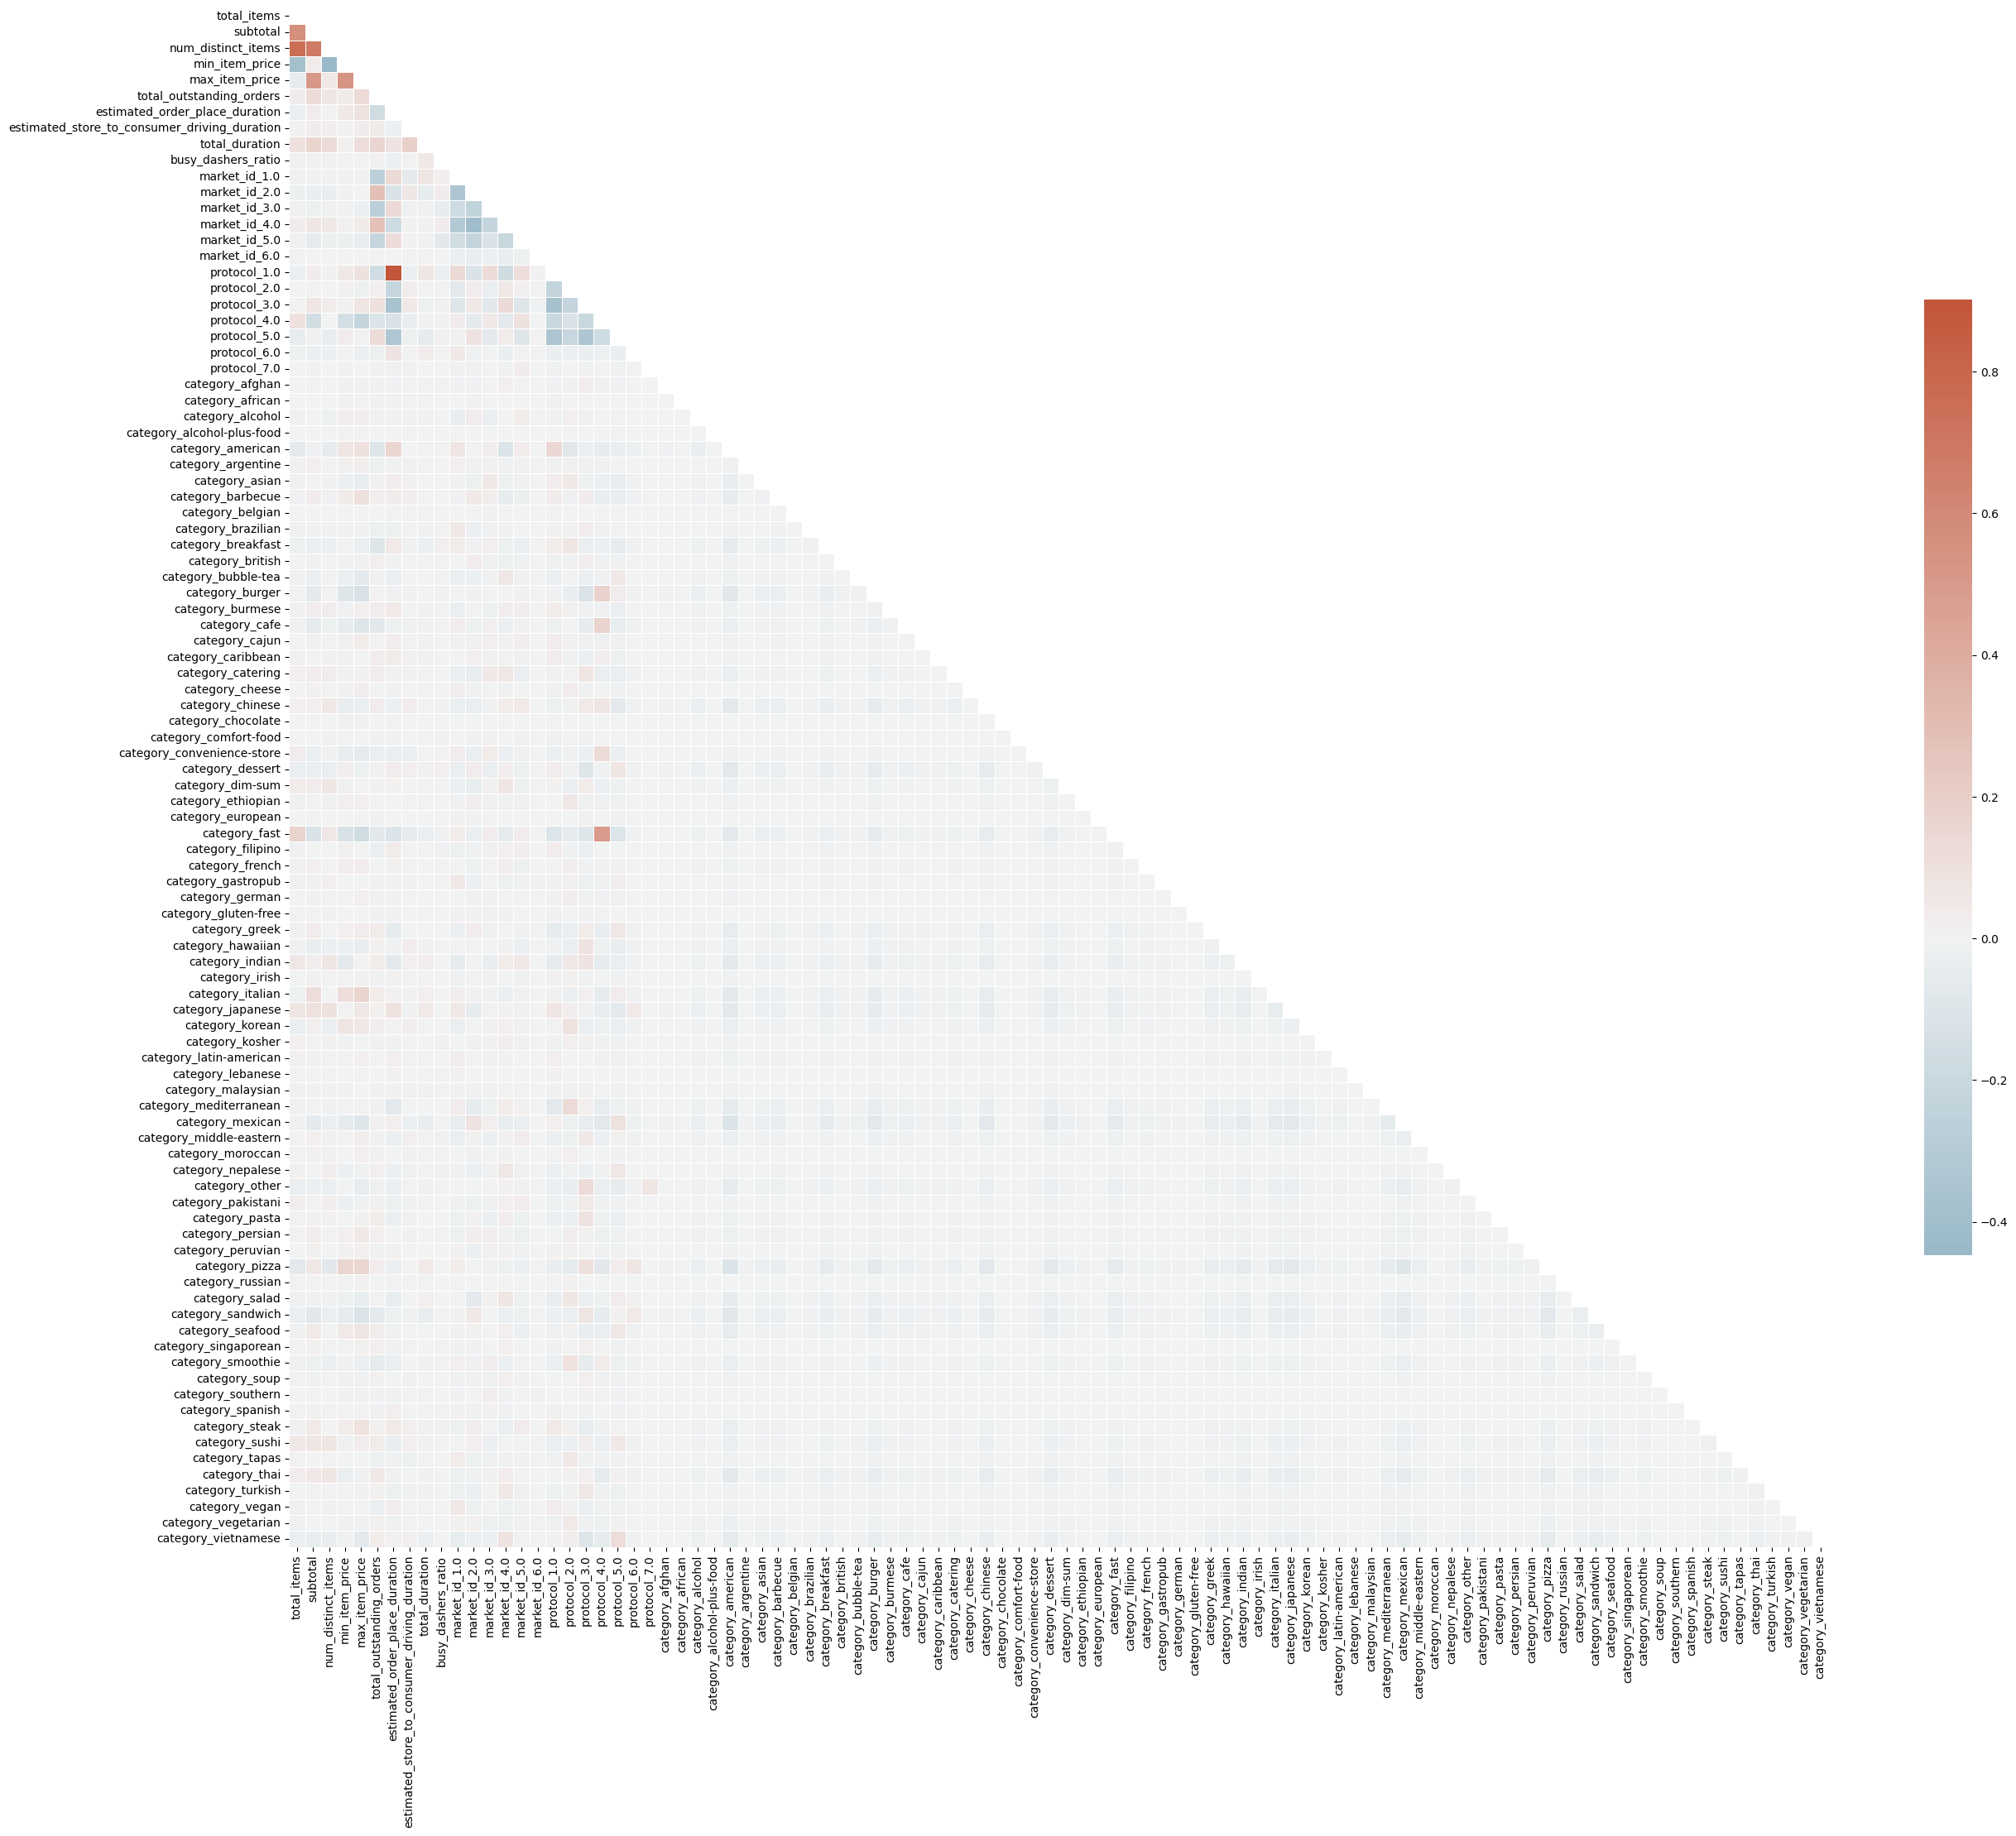

In [127]:
f,ax = plt.subplots(figsize =(30,30))
cmap = sns.diverging_palette(230,20, as_cmap=True)
sns.heatmap(corrmatrix,mask=mask,cmap=cmap,square=True,center=0,linewidths=0.5,cbar_kws={"shrink":0.5})
plt.show()


In [123]:
deliv_times.category_indonesian.describe()

count    172198.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: category_indonesian, dtype: float64

In [124]:
deliv_times.drop(columns='category_indonesian',inplace=True)

In [129]:
deliv_times.shape

(172198, 96)

In [72]:
def get_redundant_pairs(df):
    pairs_to_drop =set()
    cols = df.columns
    for i in range(df.shape[1]):
        for j in range(i+1):
            pairs_to_drop.add((cols[i],cols[j]))
    return pairs_to_drop

In [69]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [83]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(deliv_times, 20))

Top Absolute Correlations
estimated_order_place_duration  protocol_1.0          0.901272
total_items                     num_distinct_items    0.756580
subtotal                        num_distinct_items    0.682449
total_items                     subtotal              0.554725
min_item_price                  max_item_price        0.539908
subtotal                        max_item_price        0.509085
protocol_4.0                    category_fast         0.500561
num_distinct_items              min_item_price        0.447473
market_id_2.0                   market_id_4.0         0.405962
total_items                     min_item_price        0.389448
protocol_1.0                    protocol_3.0          0.372888
estimated_order_place_duration  protocol_3.0          0.362457
protocol_1.0                    protocol_5.0          0.342623
protocol_3.0                    protocol_5.0          0.338718
market_id_1.0                   market_id_2.0         0.338260
estimated_order_place_duratio

In [74]:
deliv_times.drop(columns=[],inplace=True)

In [86]:
deliv_times.columns.__len__()

96